## 1

In [16]:
import time
import requests

api_url = 'https://test.deribit.com/api/v2/'

request_payload = {
    "jsonrpc": "2.0",
    "id": 833,
    "method": "public/get_tradingview_chart_data",
    "params": {
        "instrument_name": "BTC-PERPETUAL",
        "end_timestamp": int(time.time() * 1000),  # Current time in milliseconds
        "start_timestamp": int((time.time() - 1e6) * 1000),  # One million seconds ago in milliseconds
        "resolution": "60"  # Data resolution in minutes
    }
}

response = requests.post(api_url, json=request_payload)
data = response.json()


## 2

In [17]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [18]:
import pandas as pd
from sqlalchemy import create_engine

# Convert response data to DataFrame
ohlc_data = pd.DataFrame(data['result'])
ohlc_data['timestamp'] = pd.to_datetime(ohlc_data['ticks'], unit='ms')
ohlc_data['instrument_name'] = "BTC-PERPETUAL"
ohlc_data['resolution'] = 60

# Remove unnecessary columns
ohlc_data.drop(columns=['ticks', 'status'], inplace=True)

# Display the DataFrame
display(ohlc_data)

# Establish a connection to the SQLite database
db_engine = create_engine('sqlite:///07_datam.db')

# Insert the data into the database
ohlc_data.to_sql("ohlc", db_engine, if_exists="replace", index=False)


,volume,cost,open,low,high,close,timestamp,instrument_name,resolution
0,29.122696,1963060.0,67885.0,67149.5,67885.0,67317.5,2024-05-24 05:00:00,BTC-PERPETUAL,60
1,22.256623,1499400.0,67256.0,66942.0,67525.5,66942.0,2024-05-24 06:00:00,BTC-PERPETUAL,60
2,788.578318,52923300.0,66891.0,66835.5,67349.0,67108.5,2024-05-24 07:00:00,BTC-PERPETUAL,60
3,7.716466,517540.0,67173.0,66647.0,67248.0,67140.5,2024-05-24 08:00:00,BTC-PERPETUAL,60
4,93.381457,6276980.0,67128.5,67043.0,67381.5,67381.5,2024-05-24 09:00:00,BTC-PERPETUAL,60
...,...,...,...,...,...,...,...,...,...
274,100.523466,6983770.0,69404.0,69404.0,70508.0,70505.5,2024-06-04 15:00:00,BTC-PERPETUAL,60
275,328.731743,23305640.0,70554.0,70471.0,71096.0,70844.0,2024-06-04 16:00:00,BTC-PERPETUAL,60
276,15.699755,1109730.0,70824.5,70650.5,70911.0,70650.5,2024-06-04 17:00:00,BTC-PERPETUAL,60
277,18.522800,1309340.0,70695.0,70650.5,70721.0,70650.5,2024-06-04 18:00:00,BTC-PERPETUAL,60


279

## 3

{'usOut': 1717529023162627, 'usIn': 1717529023162624, 'usDiff': 3, 'testnet': False, 'jsonrpc': '2.0', 'error': {'message': 'Method not found', 'code': -32601}}
Error: 'result' not found in the response.


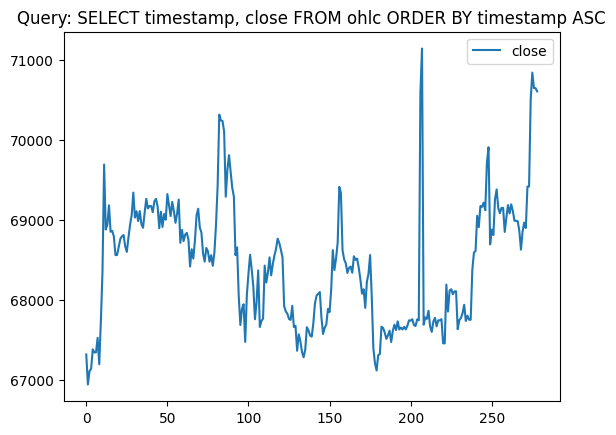

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from sqlalchemy import create_engine
import requests
import time

class DataProcessor:
    def __init__(self, database_name):
        self.engine = create_engine(f'sqlite:///{database_name}')
        self.api_url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"
        
    def fetch_data(self, instrument):
        request_payload = {
            "jsonrpc": "2.0",
            "id": 833,
            "method": "public/get_tradingview_chart_data",
            "params": {
                "instrument_name": instrument,
                "end_timestamp": int(time.time() * 1000),  # Current time in milliseconds
                "start_timestamp": int((time.time() - 1e6) * 1000),  # One million seconds ago in milliseconds
                "resolution": "60"  # Data resolution in minutes
            }
        }
        response = requests.post(self.api_url, json=request_payload)
        result = response.json()
        
        # Debug: Print the response to see its structure
        print(result)
        
        if 'result' in result:
            ohlc_data = pd.DataFrame(result['result'])
            ohlc_data['timestamp'] = pd.to_datetime(ohlc_data['ticks'], unit='ms')
            ohlc_data['instrument_name'] = instrument
            ohlc_data['resolution'] = 60
            ohlc_data.drop(columns=['ticks', 'status'], inplace=True)
            ohlc_data.to_sql('ohlc', self.engine, if_exists='replace', index=False)
        else:
            print("Error: 'result' not found in the response.")
            return None
        
    def execute_query(self, sql_query):
        return pd.read_sql(sql_query, self.engine)
        
    def display_chart(self, sql_query):
        data_frame = self.execute_query(sql_query)
        data_frame.plot()
        plt.title(f'Query: {sql_query}')
        plt.show()

# Initialize the DataProcessor class
dp = DataProcessor('07_datam.db')

# Fetch and store data for BTC-PERPETUAL
dp.fetch_data('BTC-PERPETUAL')

# Retrieve data from the database
data = dp.execute_query('SELECT * FROM ohlc')

# Plot the data
dp.display_chart('SELECT timestamp, close FROM ohlc ORDER BY timestamp ASC')
